## Is it a bird?

In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
    print('Connected to the internet')
except socket.error as ex: 
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Connected to the internet


## Step 1: Download images of birds and non-birds

In [16]:
# installed the fastai and duckduckgo_search packages in my local env
#   source ~/Library/jupyterlab-desktop/envs/jupyter_lab/bin/activate 
#   pip3 install --upgrade duckduckgo_search fastai


In [18]:
from duckduckgo_search import DDGS 
from fastcore.all import *

def search_images(term, max_images=200): 
    ddgs = DDGS() 
    return L(ddgs.images(term, max_results=max_images)).itemgot('image')

In [19]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

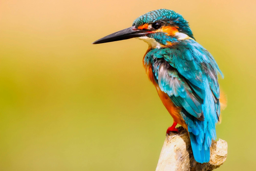

In [31]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

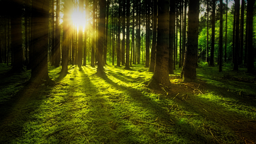

In [22]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [23]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [24]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

64

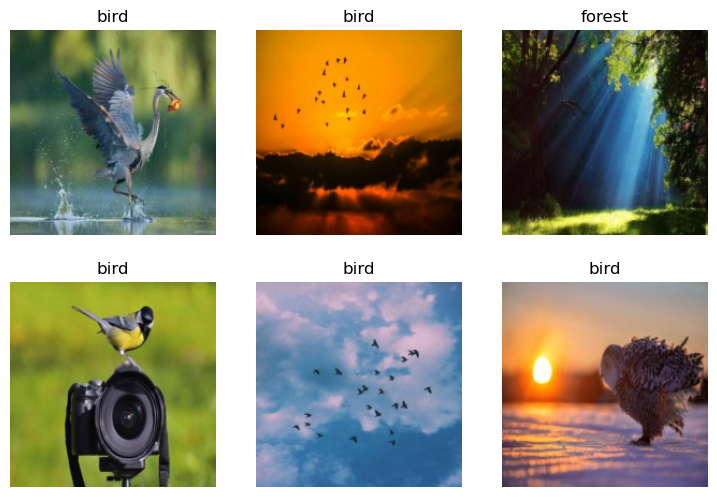

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rohit/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 63.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.565741,0.048174,0.011429,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.083901,0.032578,0.017143,00:05
1,0.059117,0.022637,0.011429,00:03
2,0.037041,0.015647,0.005714,00:03


## Step 3: Use our model (and build your own!)

In [32]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


## Example 2 -- Segmentation 

We will now train the restnet34 to do segmentation. We will ask the model to color each pixel per segementation

In [33]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)


In [34]:
print(path)

/Users/rohit/.fastai/data/camvid_tiny


In [35]:
# we use a unet learner instead of prevous vision learner. 
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)


epoch,train_loss,valid_loss,time
0,3.566267,2.153027,00:05


epoch,train_loss,valid_loss,time
0,1.997722,1.522726,00:02
1,1.737208,1.208034,00:01
2,1.557537,1.149814,00:01
3,1.390951,0.851715,00:01
4,1.254533,0.796012,00:01
5,1.134076,0.732358,00:01
6,1.030272,0.677804,00:01
7,0.949032,0.676549,00:01


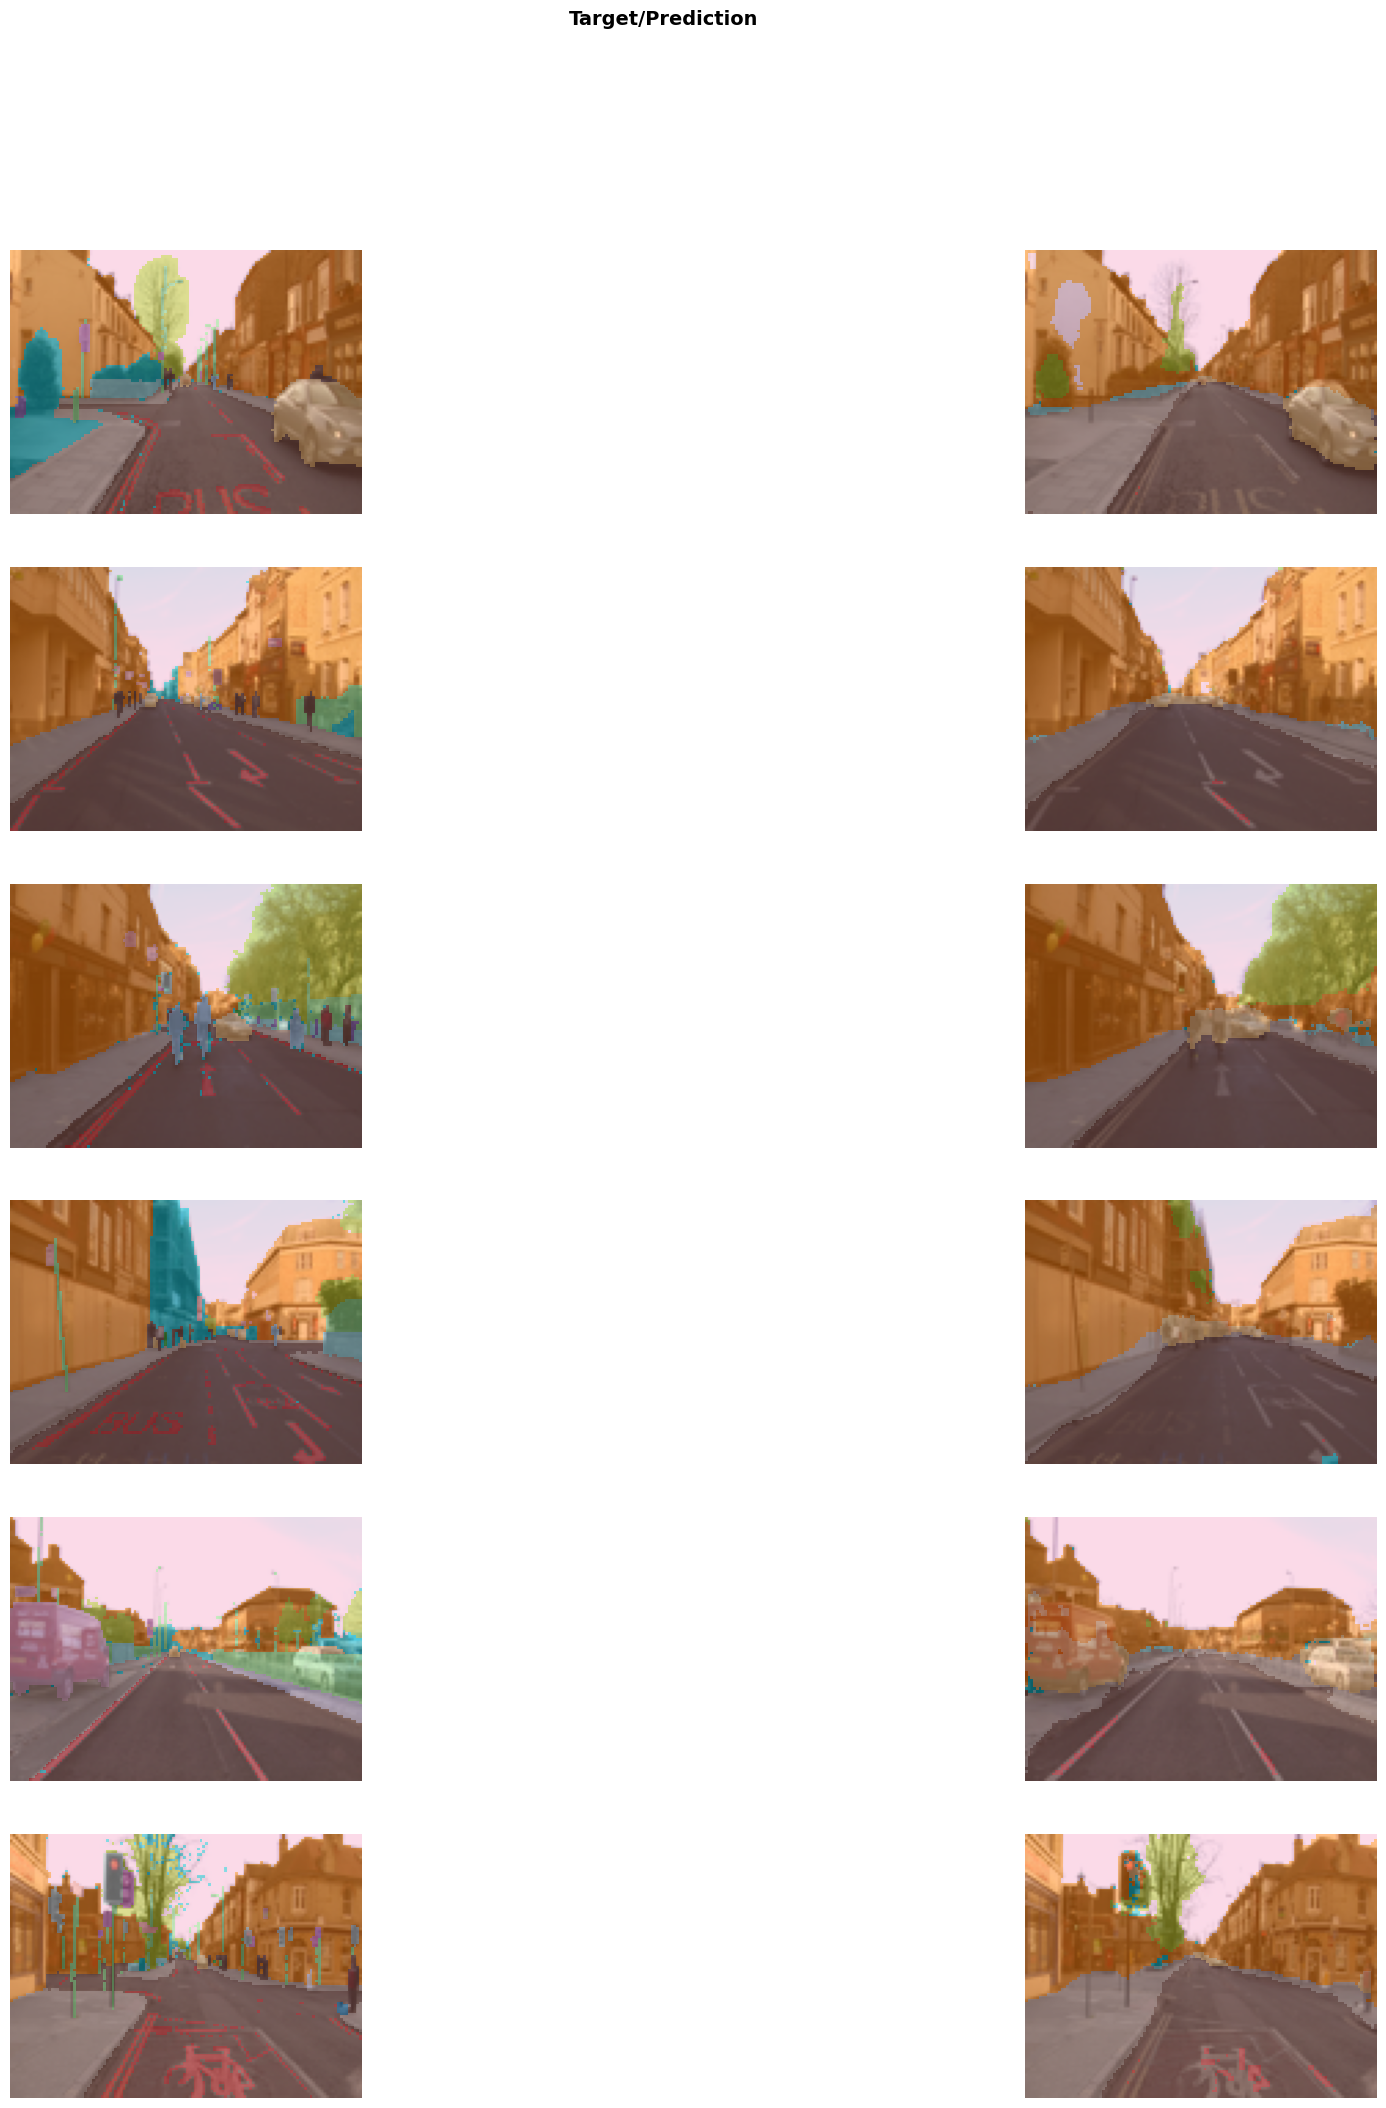

In [38]:
learn.show_results(max_n=6, figsize=(24,24))


## NLP sentiment analysis 
We will use IMDB database on top of AWD_LSTM base model to do sentiment analysis. 


In [40]:
from fastai.text.all import *

# My macbook ran out of memory after 10 mins of running. Trying again with bs=16 to reduce the batch-size. 
# This failed even with bs=16. I am going to bail out on this experiment for now and try out on a beefier cloud machine later. 
#  Or try to figure out some settings that I can use for PyTorch to use more meomroy
#  
#dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=16)
#learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
#learn.fine_tune(4, 1e-2)
# this model runs very slowly on my macbook and took 30 mins

/Users/rohit/Library/jupyterlab-desktop/envs/jupyter_lab/lib/python3.12/site-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.

epoch,train_loss,valid_loss,accuracy,time
0,0.623468,0.554135,0.735120,21:19


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: MPS backend out of memory (MPS allocated: 12.14 GB, other allocations: 8.25 GB, max allowed: 20.40 GB). Tried to allocate 91.56 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [41]:
learn.predict("I really liked that movie!")


('pos', tensor(1), tensor([0.4432, 0.5568]))

## Tabular data..
We will load salaray data and build a predictor. In this case we won't do transfer-learning but rather directly traine the model 

In [43]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

tab_learn = tabular_learner(dls, metrics=accuracy)


/Users/rohit/Library/jupyterlab-desktop/envs/jupyter_lab/lib/python3.12/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [44]:
# Note that we are running fit.. and not fine_tune on the learner
tab_learn.fit_one_cycle(3)


epoch,train_loss,valid_loss,accuracy,time
0,0.373432,0.374805,0.830160,00:12
1,0.362190,0.355884,0.833999,00:03
2,0.352185,0.353109,0.837531,00:03


In [46]:
tab_learn.show_results(max_n=3)# i added this but not sure how to interpret the table below. 


,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,12.0,5.0,2.0,3.0,5.0,1.0,-1.06929,-0.053673,-0.422589,0.0,0.0
1,5.0,12.0,3.0,5.0,6.0,5.0,1.0,-0.48446,1.082189,-0.422589,0.0,1.0
2,5.0,12.0,5.0,13.0,4.0,5.0,1.0,-1.43481,0.165449,-0.422589,0.0,0.0


## Recommendation -- collaborative filtering 

Let's use movie ratings to predict what movie you may like. Note that we are using fine_tune for this case and building on top of an existing model. 

In [47]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)


epoch,train_loss,valid_loss,time
0,1.600375,1.354683,00:02


epoch,train_loss,valid_loss,time
0,1.432137,1.309919,00:00
1,1.340186,1.176042,00:00
2,1.109719,0.920584,00:00
3,0.836638,0.764733,00:00
4,0.704512,0.714082,00:00
5,0.624335,0.701979,00:00
6,0.599464,0.696794,00:00
7,0.591604,0.690133,00:00
8,0.588204,0.687432,00:00
9,0.596707,0.687254,00:00
